# EDA and Machine Learning Setup

In [1]:
import yaml
import time
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import warnings
import sqlalchemy
from sqlalchemy import Table, Column, Integer, String, MetaData, Date, Boolean, create_engine, Float, and_
from sqlalchemy.sql import select, insert

# SKLearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Pipeline, Gridsearch, train_test_split
from sklearn.model_selection import GridSearchCV

# Plot the confusion matrix at the end of the tutorial
from sklearn.metrics import plot_confusion_matrix, classification_report

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Hidding warnings
warnings.filterwarnings('ignore')

### Importing database connection variables.

In [2]:
with open('../../../../footballYaml.yml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

football_key = config['football_key']
db_user = config["db_user"]
db_pass = config["db_pass"]
db_name = config["db_name"]
db_host = config["db_host"]

### Establishing the connection to Google SQL

In [3]:
host_args = db_host.split(":")
if len(host_args) == 1:
    db_hostname = db_host
    db_port = 5432
elif len(host_args) == 2:
    db_hostname, db_port = host_args[0], int(host_args[1])

conn = sqlalchemy.create_engine(
    # Equivalent URL:
    # postgresql+pg8000://<db_user>:<db_pass>@<db_host>:<db_port>/<db_name>
    sqlalchemy.engine.url.URL.create(
        drivername="postgresql+pg8000",
        username=db_user,  # e.g. "my-database-user"
        password=db_pass,  # e.g. "my-database-password"
        host=db_hostname,  # e.g. "127.0.0.1"
        port=db_port,  # e.g. 5432
        database=db_name  # e.g. "my-database-name"
    )
)


In [4]:
conn.connect()

Since the database tables were previously created, we retrieve the table schemas:

In [5]:
metadata = MetaData(bind=None)
table = Table(
    'match_fof', 
    metadata, 
    autoload=True, 
    autoload_with=conn
)

In [6]:
metadata = MetaData(bind=None)
table_stats = Table(
    'statistics_f1', 
    metadata, 
    autoload=True, 
    autoload_with=conn
)

Helper database functions.

In [7]:
def readDataFromSeason(table, connection, season, clean):
    if clean == True:
        stmt = select(table.columns).where(and_(table.columns.season == season, table.columns.local_goals != None))
    else:
        stmt = select(table.columns).where(and_(table.columns.season == season))
    connectionDB = connection.connect()
    return connectionDB.execute(stmt).fetchall()

In [8]:
def readStatsFromSeason(table, connection, season, clean):
    if clean == True:
        stmt = select(table.columns).where(and_(table.columns.season == season, table.columns.appearences != None))
    else:
        stmt = select(table.columns).where(and_(table.columns.season == season))
    connectionDB = connection.connect()
    return connectionDB.execute(stmt).fetchall()

## Exploratory Data Analysis (EDA)

### Seasons data frame

In [9]:
eda_seasons = [2019,2020,2021]
columnas = ["match_id", "season", "match_date", "local_team", "away_team","local_goals","away_goals"]

In [10]:
seasons_df = None

for year in eda_seasons:
    fe_year = readDataFromSeason(table,conn,year, False)
    if(seasons_df == None):
        seasons_df = fe_year
    else:
        seasons_df = seasons_df + fe_year

In [11]:
seasons_df=pd.DataFrame(seasons_df)
seasons_df.columns = columnas

In [12]:
seasons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   match_id     1140 non-null   int64  
 1   season       1140 non-null   int64  
 2   match_date   1140 non-null   object 
 3   local_team   1140 non-null   object 
 4   away_team    1140 non-null   object 
 5   local_goals  1058 non-null   float64
 6   away_goals   1058 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 62.5+ KB


<AxesSubplot:>

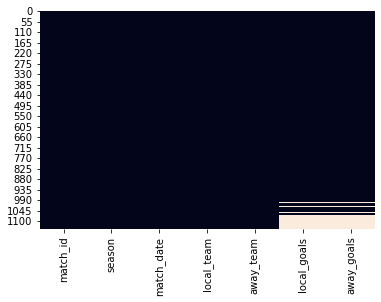

In [13]:
sns.heatmap(seasons_df.isnull(), cbar=False)

As you can see we have a few missing values on the local and away goals. So, we will count the missing values and analyze why they are missing. Depending on this, we will decide whether to drop or fill them. 

In [14]:
local_na = len(seasons_df[seasons_df['local_goals'].isnull()])
away_na = len(seasons_df[seasons_df['away_goals'].isnull()])

print(f"The NA's for local goals are:{local_na}")
print(f"The NA's for local goals are:{away_na}")

The NA's for local goals are:82
The NA's for local goals are:82


In [15]:
seasons_df[seasons_df['local_goals'].isnull()]

,match_id,season,match_date,local_team,away_team,local_goals,away_goals
930,931,2021,2022-05-19,Aston Villa,Burnley,NaN,NaN
931,932,2021,2022-04-20,Everton,Leicester,NaN,NaN
942,943,2021,2022-04-06,Burnley,Everton,NaN,NaN
966,967,2021,2022-05-11,Leicester,Norwich,NaN,NaN
977,978,2021,2022-05-12,Tottenham,Arsenal,NaN,NaN
...,...,...,...,...,...,...,...
1135,1136,2021,2022-05-22,Crystal Palace,Manchester United,NaN,NaN
1136,1137,2021,2022-05-22,Leicester,Southampton,NaN,NaN
1137,1138,2021,2022-05-22,Liverpool,Wolves,NaN,NaN
1138,1139,2021,2022-05-22,Manchester City,Aston Villa,NaN,NaN


As you can see, according to the match date, the missing values correspond to matches for the rest of the year 2022. We will explore if this is true.

In [16]:
df_null = seasons_df[seasons_df['local_goals'].isnull()].copy()
df_null['year'] = df_null['match_date'].astype(str).str[0:4]
df_null['year'] = df_null['year'].astype(int)
df_null.year.unique()

array([2022])

In [17]:
df_null[df_null['year'] == 2021]

,match_id,season,match_date,local_team,away_team,local_goals,away_goals,year


We notice that the result of the previous dataframe is empty because all matches were played. But in a previous analysis the matches were scheduled for the end of the year, but were not played.

E.g. As of march 2022 this match hasn't been played yet. On april this game was played.

![image](image_nullmatch.png)

We conclude that since the missing data correspond to rescheduled games or games that haven't been played yet, therefore we drop these rows because they don't add value.

In [18]:
seasons_df = seasons_df[seasons_df['away_goals'].notnull()]

<AxesSubplot:>

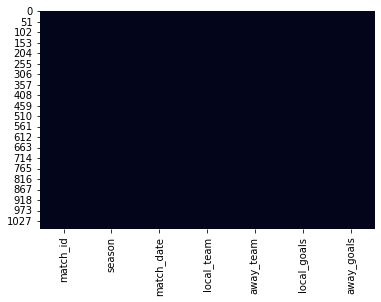

In [19]:
sns.heatmap(seasons_df.isnull(), cbar=False)

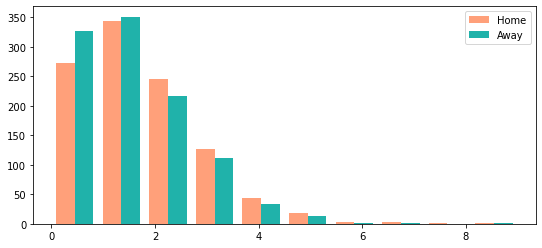

In [20]:
fig, ax = plt.subplots(figsize=(9,4)) 
plt.hist(seasons_df[['local_goals', 'away_goals']].values, 
          label=['Home', 'Away'], color=["#FFA07A", "#20B2AA"])
plt.legend(['Home', 'Away'])
plt.show()

The histogram shows an interesting structure. We can see that the frequency of teams scoring zero goals is bigger for away teams than for home teams. In general, away teams tend to score less goals. This shows the importance of considering in our model the home or away condition.

On the other hand, we can notice there are teams that in a match performed more than six goals, but as you can see these are uncommon events. Under this condition we removed this atypical results because it could represent a bias factor for the proposed model.

The count of games for different number of goals: 

In [21]:
pd.DataFrame(seasons_df[["local_goals", "away_goals"]].max(axis=1).value_counts())

,0
2.0,347
1.0,301
3.0,220
4.0,76
0.0,69
5.0,33
6.0,5
7.0,4
9.0,2
8.0,1


There are only 12 mathes where one of the teams performed more than 6 goals, 5 matches with 6 goals, 4 with 7, 2 with 9 and 1 with 8 goals, for this reason we will delete of the table in order to ajust our model.

In [22]:
seasons_df = seasons_df[seasons_df["local_goals"]<6]

In [23]:
seasons_df = seasons_df[seasons_df["away_goals"]<6]

Finally, the histogram of goals by away and home condition removing the atypical results is:

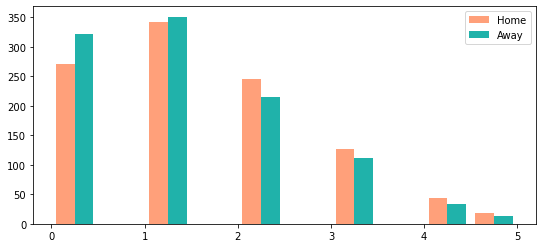

In [24]:
fig, ax = plt.subplots(figsize=(9,4)) 
plt.hist(seasons_df[['local_goals', 'away_goals']].values, color=["#FFA07A", "#20B2AA"])
plt.legend(['Home', 'Away'])
plt.show()

## Statistics dataframe

In [25]:
statistics_df = None
columns = ["season","player_id", "player_name","age","injured","team_id","appearences","minutes","position","rating","shots","goals","assists","passes_accuracy","total_duels","won_duels"]

In [26]:
for year in eda_seasons:
    fe_year = readStatsFromSeason(table_stats, conn, year, False)
    if(statistics_df == None):
        statistics_df = fe_year
    else:
        statistics_df = statistics_df + fe_year

In [27]:
statistics_df=pd.DataFrame(statistics_df)
statistics_df.columns = columns

In [28]:
statistics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           2152 non-null   int64  
 1   player_id        2152 non-null   int64  
 2   player_name      2152 non-null   object 
 3   age              2148 non-null   float64
 4   injured          2152 non-null   bool   
 5   team_id          2152 non-null   int64  
 6   appearences      2106 non-null   float64
 7   minutes          2106 non-null   float64
 8   position         2152 non-null   object 
 9   rating           1534 non-null   float64
 10  shots            1354 non-null   float64
 11  goals            2106 non-null   float64
 12  assists          763 non-null    float64
 13  passes_accuracy  1544 non-null   float64
 14  total_duels      1527 non-null   float64
 15  won_duels        1505 non-null   float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 2

In [29]:
statistics_df.shape

(2152, 16)

<AxesSubplot:>

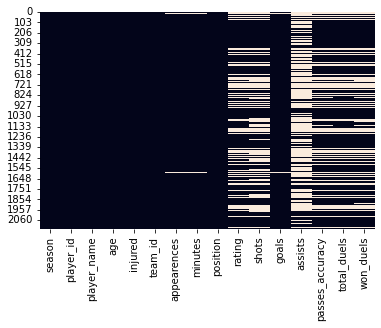

In [30]:
sns.heatmap(statistics_df.isnull(), cbar=False)

We have a lot variables with null values. The idea is to inspect each variable. In the first place we will analize assists variable. If we compare the assist values with the position it is possible to understand the reason why a lot of this values are null.

In [31]:
statistics_df.groupby("position")["assists"].count()

position
Attacker      214
Defender      215
Goalkeeper      7
Midfielder    327
Name: assists, dtype: int64

In [32]:
statistics_df.groupby("position")["assists"].apply(lambda x: x.isnull().sum())

position
Attacker      228
Defender      490
Goalkeeper    237
Midfielder    434
Name: assists, dtype: int64

As you can see, the position with more NaN's values is the goalkeeper and it is common in the football. We can see that defender is a position with a not assist and this is natural. But to understand if this variable is informative or not we can compare the ratings. We assume that if the average rating per player is different then this variable will be necessary to consider in our model or we can remove it.

In [33]:
statistics_df[statistics_df['assists'].notnull()].groupby("position")["rating","appearences"].mean()

,rating,appearences
position,,
Attacker,6.873266,25.383178
Defender,6.899280,23.776744
Goalkeeper,6.947281,31.000000
Midfielder,6.905998,24.691131


In [34]:
statistics_df[statistics_df['assists'].isnull()].groupby("position")["rating"].mean()

position
Attacker      6.568112
Defender      6.752531
Goalkeeper    6.752799
Midfielder    6.616586
Name: rating, dtype: float64

We can see that the ratings increase when the players have assist, that means that the ratings contain the information about assist and we can consider remove of the study. More over, if the rating is very informative that means that we can think on the appearence variable and consider: the higher the rating there are more appearence. Let's see!

In [35]:
statistics_df[statistics_df['assists'].notnull()].groupby("position")["rating","appearences"].mean()

,rating,appearences
position,,
Attacker,6.873266,25.383178
Defender,6.899280,23.776744
Goalkeeper,6.947281,31.000000
Midfielder,6.905998,24.691131


In [36]:
statistics_df[statistics_df['assists'].isnull()].groupby("position")["rating","appearences"].mean()

,rating,appearences
position,,
Attacker,6.568112,5.770270
Defender,6.752531,8.917895
Goalkeeper,6.752799,8.133047
Midfielder,6.616586,6.585956


With this last result, we can consider that the rating contains information about the appearence as the assist. Meanwhile, shots, total duels and won duels are less informative variables because depend on appearence and/or assists. Therefore we can assume that all this information is summarized in the rating variable.

The last "problem", the rating variable as a lot of nulls, but depends of the appearence.

In [37]:
pd.concat([statistics_df[statistics_df["appearences"] == 0].head(),statistics_df[statistics_df["appearences"] == 0].tail()])

,season,player_id,player_name,age,injured,team_id,appearences,minutes,position,rating,shots,goals,assists,passes_accuracy,total_duels,won_duels
0,2019,160,M. Vorm,38.0,False,47,0.0,0.0,Goalkeeper,NaN,NaN,0.0,NaN,NaN,NaN,NaN
5,2019,18789,Gomes,40.0,False,38,0.0,0.0,Goalkeeper,NaN,NaN,0.0,NaN,NaN,NaN,NaN
18,2019,138936,K. Hayden,18.0,False,66,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
19,2019,144715,Bernardo Rusa,22.0,False,48,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
20,2019,161,A. Whiteman,24.0,False,47,0.0,0.0,Goalkeeper,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2135,2021,899,Andreas Pereira,26.0,False,33,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2137,2021,2294,Willian,34.0,False,42,0.0,0.0,Attacker,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2149,2021,181420,Jaime Alberto Alvarado Hoyos,23.0,False,38,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2150,2021,284185,C. Whitaker,19.0,False,45,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2151,2021,284267,I. Price,19.0,False,45,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN


Note that our ratings have null values when the player has no appearences and this is obvious, because we can't measure the performance of a player without minutes on the pitch. Then, we remove the null values of rating.

In [38]:
statistics_df1 = statistics_df[statistics_df["rating"].notnull()][["team_id","season","position","rating"]]

In [39]:
statistics_df1.head()

,team_id,season,position,rating
1,50,2019,Attacker,7.160869
2,45,2019,Midfielder,6.854285
3,45,2019,Defender,6.887500
4,46,2019,Defender,6.680000
6,38,2019,Defender,6.478571


Despite that the mean of each position about rating is near of seven, the dispertion of each one suggests that is better to consider for team_id each positon as a explanatory variable. 

## Feature Engineering

Here we make the dataframe to train our machine learning model. The steps for this will be: 

* Compute the difference between scored and received goals for each team 

* Create the result variable: win, lose or odd.

* Compute the cummulative goals scored, received and the difference between these, for each team.

In [40]:
def sumaGoles(golesEquipo, totalPartidos):
    favor = 0
    contra = 0
    diferencia = 0
    for i in range(totalPartidos):
        #print("sumando el partido "+str(i))
        favor+=golesEquipo[i][0]
        contra+=golesEquipo[i][1]
        diferencia+=golesEquipo[i][2]
    return [favor, contra, diferencia]

def FeatureEngineer(anio,partialRes):
    equipos = {} # para contar los partidos jugados por equipo
    totalGoals = {} # primero a favor, luego en contra, luego diferencia
    for res in partialRes:
        if(res[1]==anio and res[5] != None): # != None validdation required for non played matches
            #datos de equipos
            local = res[3]
            visita = res[4]

            #datos de goles
            goles_local = res[5]
            goles_visita = res[6]

            if(not (local in equipos)):
                equipos[local] = 0

            if(not (visita in equipos)):
                equipos[visita] = 0

            #logica para guardar los goles por equipo y el acumulado
            if(local in totalGoals):
                totalGoals[local].append([goles_local,goles_visita, goles_local-goles_visita])
            else:
                totalGoals[local] = [[goles_local,goles_visita, goles_local-goles_visita]]

            if(visita in totalGoals):
                totalGoals[visita].append([goles_visita, goles_local, goles_visita-goles_local])
            else:
                totalGoals[visita] = [[goles_visita, goles_local, goles_visita-goles_local]]


    featureEng = []

    for partido in partialRes:
        if (partido[1]==anio and partido[5] != None): # != None validdation required for non played matches
            #print(partido)
            local = partido[3]
            visita = partido[4]
            goles_acumulados_local = sumaGoles(totalGoals[local], equipos[local])
            goles_acumulados_visita = sumaGoles(totalGoals[visita], equipos[visita])
            
            #ahora se define si gana el local, el visita o empate
            resPredictor = 'empate'
            if(partido[5]>partido[6]):
                resPredictor = 'local'
            else:
                if(partido[5]<partido[6]):
                    resPredictor = 'visita'
            
            featureEng.append([partido[1],
                        local,
                        goles_acumulados_local[0],
                        goles_acumulados_local[1],
                        goles_acumulados_local[2],
                        equipos[local],#partidos jugados hasta el momento              
                        visita,
                        goles_acumulados_visita[0],
                        goles_acumulados_visita[1],
                        goles_acumulados_visita[2],
                        equipos[visita],#partidos jugados hasta el momento  
                        resPredictor]
                             )
            equipos[local] = equipos[local]+1
            equipos[visita] = equipos[visita]+1


    return featureEng

We obtain the training dataset

In [41]:
todos_features = None

seasons_TRAIN = [2016,2017,2018,2019]

In [42]:
for year in seasons_TRAIN:
    fe_year = FeatureEngineer(year,readDataFromSeason(table,conn,year,True))
    if(todos_features == None):
        todos_features = fe_year
    else:
        todos_features = todos_features + fe_year

We obtain the test dataset

In [43]:
test_features = None

season_TEST = [2020,2021]

In [44]:
for year in season_TEST:
    fe_year = FeatureEngineer(year,readDataFromSeason(table,conn,year,True))
    if(test_features == None):
        test_features = fe_year
    else:
        test_features = test_features + fe_year

In [45]:
def printmodelresult(mensaje, modelo,tiempo, X_t, y_t):
    print("====================================")
    print(mensaje)
    print("====================================")
    accuracy = modelo.score(X_t, y_t)
    print("tiempo estimado [segundos]")
    print(tiempo)
    print("Accuracy")
    print(accuracy)
    # creating a confusion matrix
    # plot_confusion_matrix(modelo, X_t, y_t)
    y_predict = modelo.predict(X_t)
    print(classification_report(y_t, y_predict))

In [46]:
columnas = ["temporada","local","local_goles","local_goles_recibidos","locaL_dif_goles", "local_jornadas_jugadas", "visita","visita_goles","visita_goles_recibidos","visita_dif_goles", "visita_jornadas_jugadas", "ganador"]

We split target and predictive features for train and test datasets. 

Train

In [47]:
datos_fe = pd.DataFrame(todos_features)
datos_fe.columns = columnas
X_train = datos_fe.iloc[: , 1:-1]
y_train = datos_fe.iloc[: , -1]

Test

In [48]:
datos_test = pd.DataFrame(test_features)
datos_test.columns = columnas
X_test = datos_test.iloc[: , 1:-1]
y_test = datos_test.iloc[: , -1]

In [49]:
X_test.describe()

,local_goles,local_goles_recibidos,locaL_dif_goles,local_jornadas_jugadas,visita_goles,visita_goles_recibidos,visita_dif_goles,visita_jornadas_jugadas
count,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
mean,22.958702,23.013274,-0.054572,16.706490,23.016224,23.004425,0.011799,16.702065
std,16.287885,15.299998,14.634543,10.217472,16.349887,15.403628,14.977674,10.211777
min,0.000000,0.000000,-44.000000,0.000000,0.000000,0.000000,-45.000000,0.000000
25%,10.000000,11.000000,-7.000000,8.000000,10.000000,11.000000,-7.000000,8.000000
50%,20.000000,21.000000,0.000000,16.000000,21.000000,20.500000,0.000000,16.000000
75%,33.000000,33.000000,8.000000,25.000000,33.000000,33.750000,7.000000,25.000000
max,78.000000,70.000000,55.000000,37.000000,76.000000,73.000000,53.000000,37.000000


In [50]:
y_test.describe()

count       678
unique        3
top       local
freq        268
Name: ganador, dtype: object

## Modeling

The function *ajustaPipeline* creates a pipeline with the transformation of variables, trains a model according to the parameter algorithm and selects the best hyperparametes.

In [51]:
def ajustaPipeline(grid_param_in, X_train_in,y_train_in):
    #transformador de columnas
    
    col_transformer = ColumnTransformer(
                    transformers=[
                        ('onehot', OneHotEncoder(handle_unknown = 'ignore'), ["local","visita"] )],
                    remainder='drop',
                    n_jobs=-1
                    )   
    
    pipe = Pipeline([('encoder', col_transformer), ("classifier", RandomForestClassifier())])
    # se crea gridsearch sobre pipeline
    gridsearch = GridSearchCV(pipe, param_grid=grid_param_in, cv=5, verbose=0,n_jobs=-1, scoring='accuracy') # Fit grid search

    start_time = time.time()
    best_model = gridsearch.fit(X_train_in,y_train_in)
    total_time = time.time() - start_time
    return best_model, total_time

### Logistic regresion

In [52]:
grid_param_lr = [{"classifier": [LogisticRegression()],
               "classifier__penalty": ['l2'],
               "classifier__C": np.logspace(0, 4, 10),
               "classifier__solver":['newton-cg','saga','sag','liblinear'], ##This solvers don't allow L1 penalty
               "classifier__max_iter":[20000]
                }
             ] 

In [53]:
regresion_model, tiempo_regresion = ajustaPipeline(grid_param_lr, X_train,y_train)

In [54]:
printmodelresult("Modelo de regresion logistica",regresion_model,tiempo_regresion,X_test, y_test)

Modelo de regresion logistica
tiempo estimado [segundos]
15.977553367614746
Accuracy
0.49852507374631266
              precision    recall  f1-score   support

      empate       0.31      0.08      0.13       154
       local       0.49      0.78      0.60       268
      visita       0.55      0.46      0.50       256

    accuracy                           0.50       678
   macro avg       0.45      0.44      0.41       678
weighted avg       0.47      0.50      0.46       678



### KNN

In [55]:
grid_param_knn = [{"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": [1,3,5,7,10,15,20,25,50,100],
                 "classifier__weights":['uniform','distance'],
                 "classifier__algorithm":['auto','ball_tree','kd_tree']
              }]

In [56]:
knn_model, tiempo_knn = ajustaPipeline(grid_param_knn, X_train,y_train)

In [57]:
printmodelresult("Modelo de Knn",knn_model,tiempo_knn,X_test, y_test)

Modelo de Knn
tiempo estimado [segundos]
9.278641700744629
Accuracy
0.4808259587020649
              precision    recall  f1-score   support

      empate       0.00      0.00      0.00       154
       local       0.45      0.92      0.60       268
      visita       0.61      0.31      0.41       256

    accuracy                           0.48       678
   macro avg       0.35      0.41      0.34       678
weighted avg       0.41      0.48      0.39       678



### SVM

In [58]:
grid_param_svm = [{"classifier": [SVC(kernel='linear', probability=True, random_state=0)],
                 "classifier__C": [0.00001,0.0001,0.001,0.01,0.1,1,10],
                 "classifier__kernel":['linear', 'rbf']}]

In [59]:
svm_model, tiempo_svm = ajustaPipeline(grid_param_svm, X_train,y_train)

In [60]:
printmodelresult("Modelo de SVM",svm_model,tiempo_svm,X_test, y_test)

Modelo de SVM
tiempo estimado [segundos]
26.612210035324097
Accuracy
0.5
              precision    recall  f1-score   support

      empate       0.43      0.02      0.04       154
       local       0.47      0.91      0.62       268
      visita       0.61      0.36      0.45       256

    accuracy                           0.50       678
   macro avg       0.50      0.43      0.37       678
weighted avg       0.51      0.50      0.42       678



### Random Forest

In [61]:
grid_param_rfc = [{"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]

In [62]:
random_forest_model, tiempo_random_forest = ajustaPipeline(grid_param_rfc,X_train,y_train)

In [63]:
printmodelresult("Modelo de Random Forest",random_forest_model,tiempo_random_forest,X_test, y_test)

Modelo de Random Forest
tiempo estimado [segundos]
1070.971183538437
Accuracy
0.47640117994100295
              precision    recall  f1-score   support

      empate       0.00      0.00      0.00       154
       local       0.45      0.94      0.61       268
      visita       0.62      0.28      0.38       256

    accuracy                           0.48       678
   macro avg       0.36      0.41      0.33       678
weighted avg       0.41      0.48      0.38       678



### Gradient Boosting

In [64]:
grid_param_gbc = [{"classifier": [GradientBoostingClassifier(subsample=0.5)],
                 "classifier__n_estimators": [50,100,150],
                 "classifier__learning_rate":[0.001,0.01,0.05,0.1,0.5,1,2,3],
                 "classifier__max_depth":[3,5,10]
              }]

In [65]:
gbc_model, tiempo_gbc = ajustaPipeline(grid_param_gbc,X_train,y_train)

In [66]:
printmodelresult("Modelo de Gradient Boosting",gbc_model,tiempo_gbc,X_test, y_test)

Modelo de Gradient Boosting
tiempo estimado [segundos]
292.2509672641754
Accuracy
0.471976401179941
              precision    recall  f1-score   support

      empate       0.11      0.01      0.01       154
       local       0.45      0.91      0.60       268
      visita       0.60      0.29      0.39       256

    accuracy                           0.47       678
   macro avg       0.39      0.40      0.34       678
weighted avg       0.43      0.47      0.39       678



### Perceptron

In [67]:
grid_param_perc = [{"classifier": [MLPClassifier()],
                 "classifier__max_iter": [150,200,300,450],
                 "classifier__learning_rate":['constant', 'invscaling', 'adaptive'],
                 "classifier__solver":['lbfgs', 'sgd', 'adam']
              }]

In [ ]:
perc_model, tiempo_perc = ajustaPipeline(grid_param_perc,X_train,y_train)

In [ ]:
printmodelresult("Modelo de Perceptron",perc_model,tiempo_perc,X_test, y_test)

## Selected model 

According to the result based on the precision, the best performing model is SVM.  

### References: 

* [Football API.](https://www.api-football.com/)
* [Scikit-Learn User guide.](https://scikit-learn.org/stable/user_guide.html)